In [140]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from matplotlib.lines import Line2D
import community.community_louvain as community_louvain
import networkx as nx
import pandas as pd
import numpy as np
from qiime2 import Artifact
from skbio.stats.composition import clr
from scipy.stats import pearsonr

%matplotlib inline

In [218]:
tax_p_df = Artifact.load("Data/tax-6-psuedo-table.qza").view(pd.DataFrame)

tax_mat = np.matrix(tax_p_df)
tax_mat /= np.sum(tax_mat, axis=1)

tax_p_df = pd.DataFrame(tax_mat,
                   index=tax_p_df.index,
                   columns=tax_p_df.columns)

In [220]:
tax_df_clr = pd.DataFrame(clr(tax_p_df),
                          index=tax_p_df.index,
                          columns=tax_p_df.columns)

clr_pear = tax_df_clr.corr()

links = clr_pear.stack().reset_index()
links.columns = ['var1', 'var2', 'value']


links_filtered=links.loc[ (links['value'] > 0.8) & (links['var1'] != links['var2']) ]

for ind in links_filtered.index:
    r, p = pearsonr(tax_df_clr[links_filtered.loc[ind,"var1"]],
                    tax_df_clr[links_filtered.loc[ind,"var2"]])
    if p > 0.05:
        links_filtered.drop(ind, inplace=True)

In [221]:
links_filtered

,var1,var2,value
525,d__Archaea;p__Euryarchaeota;c__Methanobacteria...,d__Bacteria;p__Actinobacteriota;c__Coriobacter...,0.922288
726,d__Archaea;p__Euryarchaeota;c__Methanobacteria...,d__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.881695
727,d__Archaea;p__Euryarchaeota;c__Methanobacteria...,d__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.999990
734,d__Archaea;p__Euryarchaeota;c__Methanobacteria...,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia...,0.933017
778,d__Archaea;p__Thermoplasmatota;c__Thermoplasma...,d__Bacteria;p__Actinobacteriota;c__Coriobacter...,0.928212
...,...,...,...
61453,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.997758
61474,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,0.848917
61550,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphy...,0.837976
61700,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.999896


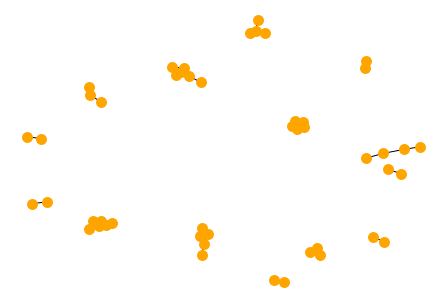

In [222]:
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2',)

nx.draw(G, node_color='orange', node_size=80, edge_color='black', linewidths=2)

plt.show()


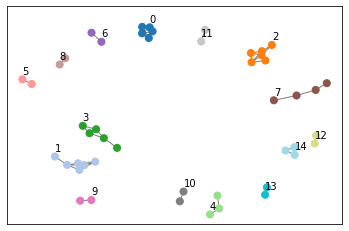

In [302]:
partition = community_louvain.best_partition(G, random_state=42)

pos = nx.spring_layout(G, k=0.2, seed=42)
# color the nodes according to their partition
cmap = cm.get_cmap('tab20')

nx.draw_networkx_nodes(G, pos, nodelist=partition.keys(), 
                       node_size=50,
                       cmap=cmap, 
                       node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)

#collapse the dict to get one in each module 
#then annotate the plot with their module number 
#there's probably a better way to do this but this works for now
for v, k in {v:k for k,v in partition.items()}.items():
    plt.annotate(s=v,
                 xy=(pos[k][0], pos[k][1]+0.05))
    
ax = plt.gca()
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], ylim[1]+0.1)

plt.show()

In [224]:
np.unique(list(partition.values()))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [284]:
np.mean([tax_p_df[k].mean() for k in partition.keys()])

5.22171331112491e-05

In [227]:
#make a list of each taxon in each module
rev_part = {i: list(dict(filter(lambda x: x[1]==i, partition.items())).keys()) for i in range(15)}

modules_df = pd.DataFrame.from_dict(rev_part, orient="index").T

In [228]:
modules_df.to_csv("Tables/tax_clr_pearson_modules.csv")

## Now add metabolites

In [206]:
metabo = pd.read_csv("Data/IBS-ID-list.txt", sep="\t", encoding='unicode_escape')

#Clean up rows and columns
metabo = metabo[metabo["Sample"].isna()==False]
metabo.loc[metabo["Subject ID.1"].isna(), "Subject ID.1"] = metabo.loc[metabo["Subject ID.1"].isna(), "Sample"]
metabo.set_index("Subject ID.1", inplace=True)
metabo.drop(["Sample", "Subject ID","Unnamed: 3"], axis=1, inplace=True)

#Clean up column names
metabo.columns = list(metabo.columns[:2]) + [" ".join(col.split(" ")[:-4]) for col in list(metabo.columns[2:])]

#Impute NQ as LLOQ/2
metabo.replace(to_replace="NQ",
               value=np.nan,
               inplace=True)

metabo.loc["LLOQ", "Sample Weight"] = 0
metabo.loc["LLOQ",:] = metabo.loc["LLOQ",:].astype(float)
metabo.loc["half LLOQ",:] = metabo.loc["LLOQ"]/2
metabo.iloc[2:-1,:] = metabo.iloc[2:-1,:].fillna(metabo.loc["half LLOQ",:])

#Drop ULOQ/LLOQ
metabo.drop(["half LLOQ","LLOQ","ULOQ", "Preservative", "BLOQ Values", "ALOQ Values"], inplace=True)

#We can drop these too - quantities are already microg/g sample weight
metabo.drop(["Sample Weight", "Date and Time"], axis=1, inplace=True)

In [209]:
#indexes are the same
print(len(set(metabo.index)&set(tax_df_clr.index))==len(tax_df_clr.index))

#reindex according to tax
metabo = metabo.reindex(tax_df_clr.index)

True


In [212]:
tax_clr_metabo = pd.concat([tax_df_clr, metabo],
                            axis=1)

In [213]:
tax_metabo_pear = tax_clr_metabo.corr()

links = tax_metabo_pear.stack().reset_index()
links.columns = ['var1', 'var2', 'value']


links_filtered=links.loc[ (links['value'] > 0.8) & (links['var1'] != links['var2']) ]

for ind in links_filtered.index:
    r, p = pearsonr(tax_clr_metabo[links_filtered.loc[ind,"var1"]],
                    tax_clr_metabo[links_filtered.loc[ind,"var2"]])
    if p > 0.05:
        links_filtered.drop(ind, inplace=True)

In [214]:
links_filtered

,var1,var2,value
535,d__Archaea;p__Euryarchaeota;c__Methanobacteria...,d__Bacteria;p__Actinobacteriota;c__Coriobacter...,0.922288
736,d__Archaea;p__Euryarchaeota;c__Methanobacteria...,d__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.881695
737,d__Archaea;p__Euryarchaeota;c__Methanobacteria...,d__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.999990
744,d__Archaea;p__Euryarchaeota;c__Methanobacteria...,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia...,0.933017
793,d__Archaea;p__Thermoplasmatota;c__Thermoplasma...,d__Bacteria;p__Actinobacteriota;c__Coriobacter...,0.928212
...,...,...,...
62760,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphy...,0.837976
62910,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.999896
65324,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysip...,0.995380
66561,palmitic acid (16:0),stearic acid (18:0),0.808975


**Looks like there isn't really anything new that came up when including lipids, except that palmitic and stearic correlate with each other**